In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

dataset_dir = '/content/drive/MyDrive/organized-dataset-fifteen'

train_dir = Path(dataset_dir) / 'train'
val_dir = Path(dataset_dir) / 'val'
test_dir = Path(dataset_dir) / 'test'

train_filepaths = list(train_dir.glob('**/*.jpg'))
val_filepaths = list(val_dir.glob('**/*.jpg'))
test_filepaths = list(test_dir.glob('**/*.jpg'))

def proc_img(filepaths):
    labels = [path.parent.name for path in filepaths]
    df = pd.DataFrame({
        'Filepath': [str(path) for path in filepaths],
        'Label': labels
    })
    return df.sample(frac=1).reset_index(drop=True)

train_df = proc_img(train_filepaths)
val_df = proc_img(val_filepaths)
test_df = proc_img(test_filepaths)

print(train_df.head())


                                            Filepath         Label
0  /content/drive/MyDrive/organized-dataset-fifte...           egg
1  /content/drive/MyDrive/organized-dataset-fifte...         flour
2  /content/drive/MyDrive/organized-dataset-fifte...     chocolate
3  /content/drive/MyDrive/organized-dataset-fifte...  chicken-meat
4  /content/drive/MyDrive/organized-dataset-fifte...         onion


In [ ]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 2893

Number of different labels: 15

Labels: ['egg' 'flour' 'chocolate' 'chicken-meat' 'onion' 'carrot' 'tomato'
 'potato' 'bread' 'rice' 'lemon' 'banana' 'pineapple' 'cheese' 'milk']


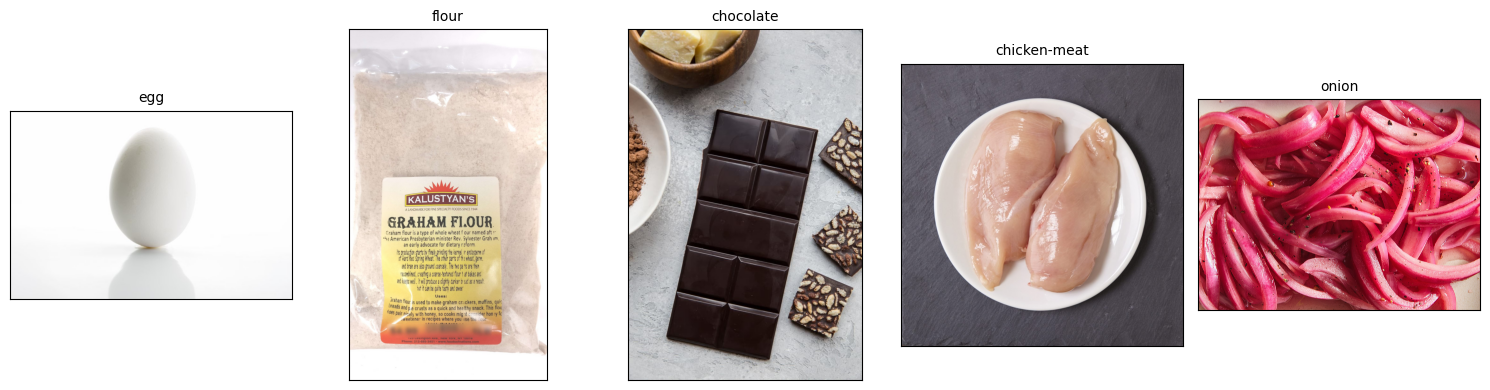

In [ ]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index(drop=True)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2893 validated image filenames belonging to 15 classes.
Found 356 validated image filenames belonging to 15 classes.
Found 371 validated image filenames belonging to 15 classes.


In [ ]:
class_indices = train_images.class_indices
CLASS_NAMES = [k for k, v in sorted(class_indices.items(), key=lambda item: item[1])]
print(CLASS_NAMES)

['banana', 'bread', 'carrot', 'cheese', 'chicken-meat', 'chocolate', 'egg', 'flour', 'lemon', 'milk', 'onion', 'pineapple', 'potato', 'rice', 'tomato']


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(15, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.5398 - loss: 1.5704 - val_accuracy: 0.8371 - val_loss: 0.6148
Epoch 2/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.9322 - loss: 0.2612 - val_accuracy: 0.8230 - val_loss: 0.5253
Epoch 3/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9604 - loss: 0.1461 - val_accuracy: 0.8680 - val_loss: 0.4984
Epoch 4/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9795 - loss: 0.0817 - val_accuracy: 0.8680 - val_loss: 0.5080
Epoch 5/5
91/91 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.9977 - loss: 0.0258 - val_accuracy: 0.8680 - val_loss: 0.4867


In [ ]:
import shutil
model.save("mobilenet_recipe_ai_ingredients.h5")

shutil.copy("mobilenet_recipe_ai_ingredients.h5", "/content/drive/MyDrive/mobilenet_recipe_ai_ingredients.h5")

'/content/drive/MyDrive/mobilenet_recipe_ai_ingredients.h5'

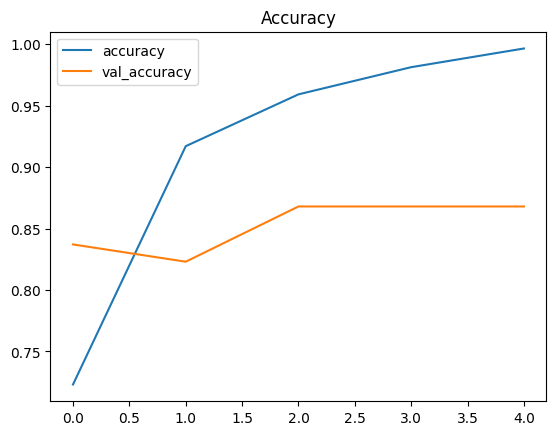

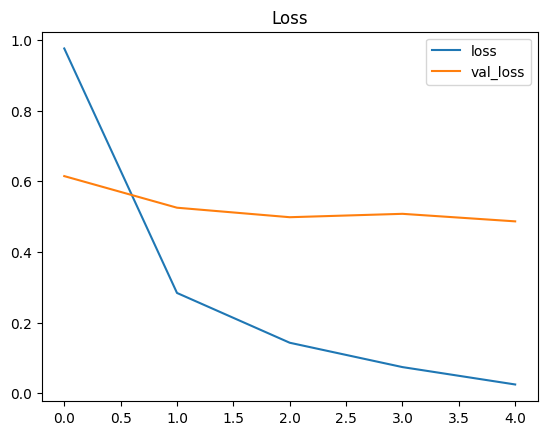

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 90.57%


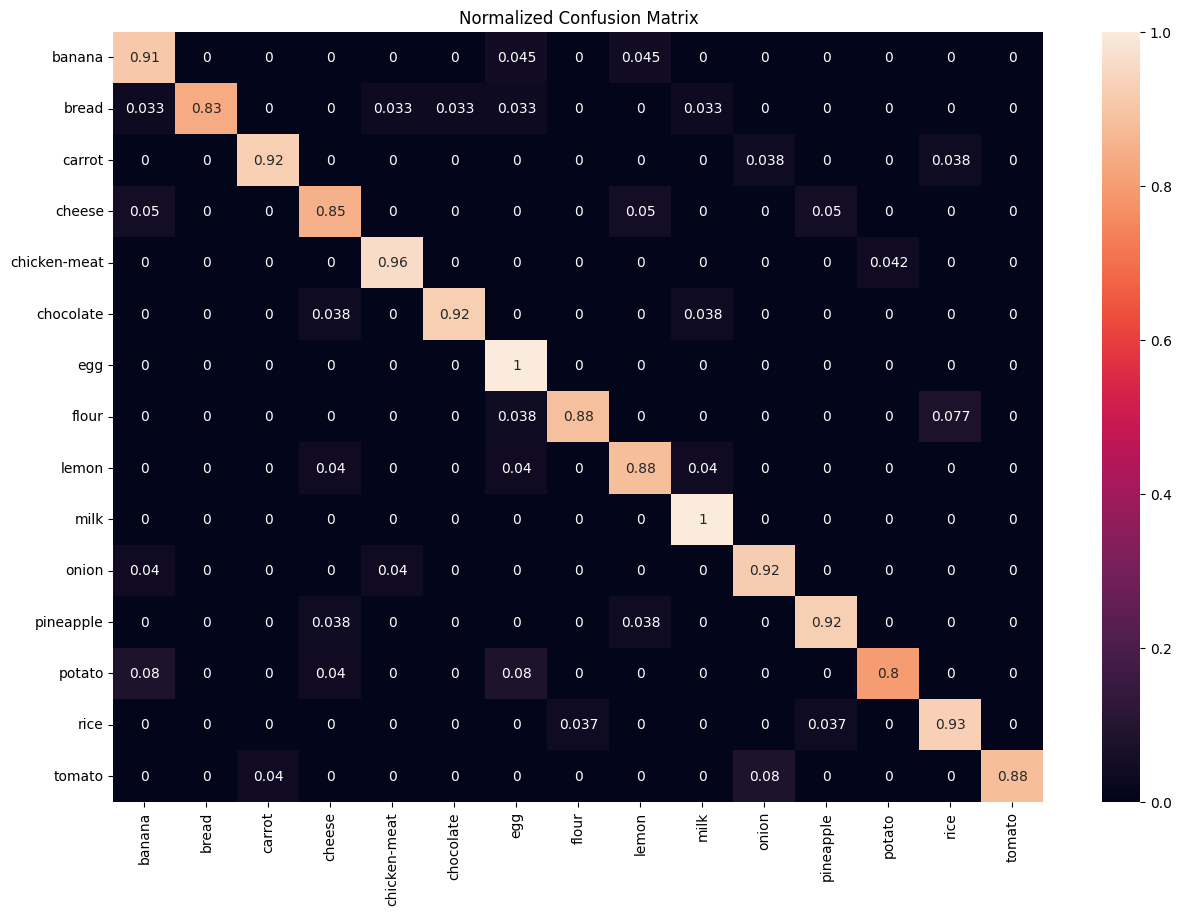

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix,
            annot=True,
            xticklabels = sorted(set(y_test)),
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()